# Data dictionary

# [Link to dataset](https://www.kaggle.com/datasets/etiennekaiser/gemini-pro-llm-daigt-dataset)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Variable Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">text</td>
    <td class="tg-7zrl">The essay created by each prompt</td>
    <td class="tg-7zrl">Text/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">label</td>
    <td class="tg-7zrl">Indicating whether the essay originated from a student (0) or was generated by a Language Model (LLM) (1)</td>
    <td class="tg-7zrl">Numeric/Binary</td>
  </tr>
  <tr>
    <td class="tg-7zrl">prompt_name</td>
    <td class="tg-7zrl">Represents which of the seven prompts was used during generation of an essay</td>
    <td class="tg-7zrl">Categorical/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">source</td>
    <td class="tg-7zrl">The used model during text generation (gemini_pro)</td>
    <td class="tg-7zrl">Categorical/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">RDizzl3_seven</td>
    <td class="tg-7zrl">Boolean flag</td>
    <td class="tg-7zrl">Boolean</td>
  </tr>
</tbody></table>

# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemini-pro-llm-daigt-dataset/train_essays_v1.csv


In [2]:
# Install dependencies (only if not already installed)
# !pip install wordcloud
!pip install rouge_score
# !pip install -q -U tensorflow-text # If using tensorflow_text specific ops

import re
import numpy as np
import pandas as pd
import pickle # For saving/loading tokenizer
import string # Import string for punctuation
from itertools import combinations

import tensorflow as tf
from tensorflow import keras # Explicitly import keras from tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# Combined all Keras layers, including LSTM and Bidirectional
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, Layer, LayerNormalization, MultiHeadAttention, LSTM, Bidirectional
# Combined optimizers (Adam and AdamW were both present in different blocks, using AdamW as specified)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Combined callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # For LabelEncoder if used
from sklearn.decomposition import PCA # For PCA if used
from sklearn.utils import shuffle

import nltk # Import NLTK for sentence tokenization
from nltk.tokenize import sent_tokenize # Specific import for sentence tokenization
from nltk.corpus import stopwords # If stopwords are used
from nltk.stem import PorterStemmer # If stemming is used

from rouge_score import rouge_scorer # For ROUGE score calculation
from wordcloud import WordCloud, STOPWORDS # Import WordCloud and STOPWORDS

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl # Often imported with matplotlib

# Optional: If you need to manipulate paths or OS commands
import os

# Download NLTK 'punkt' tokenizer data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt')
    print("NLTK 'punkt' tokenizer downloaded.")

# Download NLTK 'stopwords' data if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK 'stopwords' corpus not found. Downloading...")
    nltk.download('stopwords')
    print("NLTK 'stopwords' corpus downloaded.")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print(f"TensorFlow Version: {tf.__version__}")
# print(f"Keras Version: {keras.__version__}") # Keras is part of TensorFlow now, so tf.keras is common

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9ccf6c8011bb14b7fc5b4c1ed47b6d755c64820cb214eede5f1a8a0b616278be
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


2025-07-28 12:03:57.748449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753704237.976035      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753704238.042908      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


# Load dataset

In [3]:
df = pd.read_csv('/kaggle/input/gemini-pro-llm-daigt-dataset/train_essays_v1.csv')
df = df["text"]
df = df.to_frame()
df.head()

,text
0,The Electoral College is a complex system that...
1,"The exploration of Venus, Earth's closest plan..."
2,## Does the Electoral College Work?\n\nThe Ele...
3,"In the vast realm of literature, there exists ..."
4,"In the realm of modern transportation, the adv..."


In [4]:
# Take a 0.05% sample of the DataFrame
# random_state for reproducibility, so you get the same sample every time you run it
df = df.sample(frac=0.02, random_state=42)

print(f"Sampled DataFrame shape (50%): {df.shape}")

# Display the head of the sampled DataFrame
print("\nHead of the 50% sampled DataFrame:")
print(df.head())

Sampled DataFrame shape (50%): (70, 1)

Head of the 50% sampled DataFrame:
                                                   text
1650  The Electoral College, a system rooted in the ...
2456  In the vast expanse of the cosmos, the human g...
2232  The Facial Action Coding System (FACS), develo...
1945  The novel "A Cowboy Who Rode the Waves" by Wil...
309   ## Unveiling the Benefits of Car-Free Cities: ...


# Split data into train and test

In [5]:
# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42) 

# Print the shapes of the resulting sets
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (56, 1)
test shape: (14, 1)


# Data Visualization

In [6]:
train.shape

(56, 1)

In [7]:
train.isnull().sum()

text    0
dtype: int64

In [8]:
test.isnull().sum()

text    0
dtype: int64

In [9]:
# Check if 'text' column exists and print 5 sentences
if 'text' in train.columns:
    print("First 5 sentences from the 'text' column:")
    for i, essay_text in enumerate(train['text'].head(5)):
        print(f"--- Essay {i+1} ---")
        print(essay_text)
        print("\n") # Add an extra newline for better separation
else:
    print("Error: 'text' column not found in the DataFrame. Cannot display sentences.")

First 5 sentences from the 'text' column:
--- Essay 1 ---
In the realm of extraordinary feats, the tale of a cowboy who rode the waves stands out as a testament to the boundless nature of human spirit. This audacious adventurer, with his unwavering determination and unconventional approach, defied the societal norms and carved a new path, etching his name in the annals of history.

The cowboy, raised in the vast open ranges, was accustomed to the rhythm of the land, the rumble of hooves beneath him, and the boundless freedom of the prairie. However, an insatiable curiosity burned within him, a yearning to explore uncharted territories beyond the familiar horizon.

When whispers of the ocean's allure reached his ears, a flame was ignited in his heart. Intrigued by the vast expanse of water, the cowboy resolved to conquer this new frontier. Undeterred by the lack of conventional seafaring experience, he embarked on a journey that would redefine his destiny.

With unwavering resolve, he c

## Check number of words in longest sentence

In [10]:
# Initialize variables to store the longest sentence length and count
max_sentence_length = 0
count_longest_sentences = 0
longest_sentences_examples = [] # Optional: to store examples of longest sentences

# Iterate through each essay in the 'text' column
# Using .astype(str) to handle potential non-string entries (e.g., NaN)
for essay_text in train['text'].astype(str):
    # Split the essay into sentences using common delimiters (., !, ?)
    # The regex `(?<=[.!?])\s+` splits after a punctuation mark followed by one or more spaces.
    # This helps keep the punctuation with the sentence, but we'll strip it later.
    sentences = re.split(r'(?<=[.!?])\s+', essay_text)

    for sentence in sentences:
        # Clean up the sentence: remove leading/trailing whitespace and punctuation
        cleaned_sentence = re.sub(r'[.!?]$', '', sentence).strip()

        if cleaned_sentence: # Ensure the sentence is not empty after cleaning
            # Count words by splitting by whitespace
            word_count = len(cleaned_sentence.split())

            if word_count > max_sentence_length:
                max_sentence_length = word_count
                count_longest_sentences = 1 # Reset count for a new longest sentence
                longest_sentences_examples = [cleaned_sentence] # Start new list of examples
            elif word_count == max_sentence_length and max_sentence_length > 0:
                count_longest_sentences += 1 # Increment count if length matches current max
                longest_sentences_examples.append(cleaned_sentence) # Add to examples

print(f"\n--- Analysis Results ---")
print(f"The longest sentence length found (in words) is: {max_sentence_length}")
print(f"The number of sentences with this maximum length is: {count_longest_sentences}")

# Optional: Print examples of the longest sentences
if longest_sentences_examples:
    print("\n--- Examples of Longest Sentences ---")
    # Print up to 5 examples to avoid overwhelming output
    for i, example in enumerate(longest_sentences_examples[:5]):
        print(f"{i+1}. \"{example}\"")
    if len(longest_sentences_examples) > 5:
        print(f"... and {len(longest_longest_sentences_examples) - 5} more.")


--- Analysis Results ---
The longest sentence length found (in words) is: 54
The number of sentences with this maximum length is: 1

--- Examples of Longest Sentences ---
1. "Through the lens of historical fiction, this essay will delve into the significance of the novel and argue that it serves as a powerful testament to the indomitable spirit of the American frontier, the enduring legacy of the Old West, and the universal themes of courage, resilience, and adaptation in the face of adversity"


## Find number of vocabulary size

In [11]:
# --- Tokenization and Vocabulary Size Calculation (before cleaning) ---
# Initialize the Tokenizer.
# By default, Tokenizer converts to lowercase and removes punctuation.
# To get the vocabulary *before* cleaning (i.e., including punctuation and case differences),
# we need to set `lower=False` and `filters=''` (empty string for filters).
tokenizer_raw = Tokenizer(lower=False, filters='', oov_token="<unk>")

# Fit the tokenizer on the ORIGINAL 'text' column directly
tokenizer_raw.fit_on_texts(train['text'].astype(str)) # .astype(str) to handle potential non-string entries

# The vocabulary size is the number of unique words/tokens found (len(tokenizer_raw.word_index))
# plus 1 for the implicit padding token (index 0) used by Keras's pad_sequences.
vocabulary_size_raw = len(tokenizer_raw.word_index) + 1

print(f"The vocabulary size of the `train['text']` column before cleaning is: {vocabulary_size_raw}")
print(f"This includes {len(tokenizer_raw.word_index)} unique tokens (considering case and punctuation), plus 1 for the padding token (index 0).")
print(f"The index assigned to the Out-Of-Vocabulary (OOV) token '<unk>' is: {tokenizer_raw.word_index.get('<unk>', 'Not Found')}")

The vocabulary size of the `train['text']` column before cleaning is: 5064
This includes 5063 unique tokens (considering case and punctuation), plus 1 for the padding token (index 0).
The index assigned to the Out-Of-Vocabulary (OOV) token '<unk>' is: 1


## Visualize most frequence words in corpus

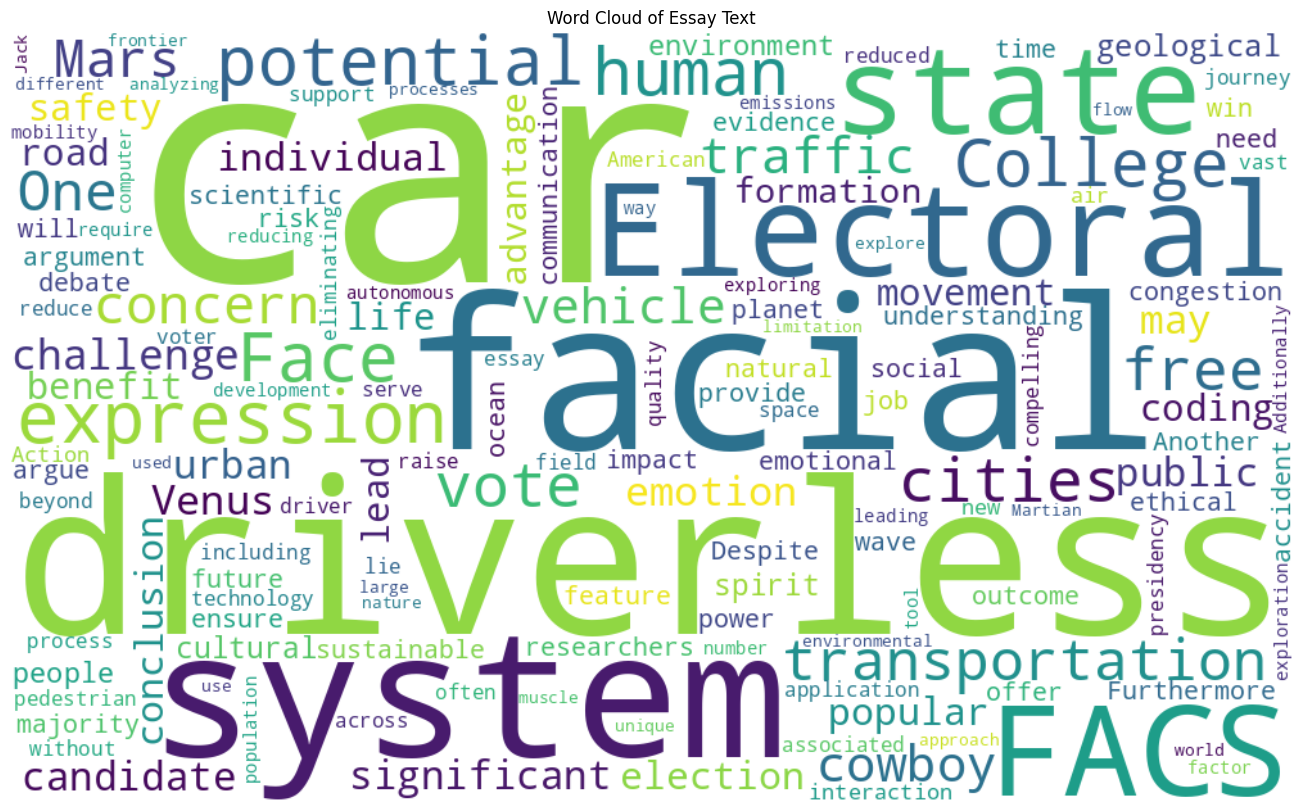

In [12]:
# Concatenate all text from the 'text' column into a single string
# Convert all entries to string type to handle potential non-string data (e.g., NaN)
all_text = ' '.join(train['text'].astype(str).tolist())

# Define stopwords (common words to exclude from the word cloud)
# You can add more domain-specific stopwords if needed
stopwords = set(STOPWORDS)
stopwords.update(["the", "a", "an", "is", "it", "this", "that", "and", "of", "to", "in", "for", "on", "with", "as", "by"]) # Add common English words

# Create a WordCloud object
# You can customize parameters like width, height, background_color, max_words, etc.
wordcloud = WordCloud(
    width=1000, # Width of the word cloud image
    height=600, # Height of the word cloud image
    background_color='white', # Background color
    stopwords=stopwords, # Words to exclude
    min_font_size=10, # Minimum font size for words
    max_words=150, # Maximum number of words to display
    collocations=False # Set to False to prevent plotting words that frequently appear together
).generate(all_text)

# Display the generated image:
plt.figure(figsize=(20, 10)) # Set figure size for better display
plt.imshow(wordcloud, interpolation='bilinear') # Display the word cloud
plt.axis("off") # Turn off axis labels
plt.title("Word Cloud of Essay Text") # Add a title
plt.show()

# Data Preprocessing

## Text Cleaning

In [13]:
# --- Dataset Cleaning & Sentence Tokenization ---
# This clean_text function is adapted from your provided pipeline (using string.punctuation)
def clean_text_from_provided_pipeline(txt):
    txt = str(txt) # Ensure text is string
    # Remove punctuation and convert to lowercase
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    # Encode to utf8 and decode to ascii, ignoring errors (removes non-ascii chars)
    txt = txt.encode("utf8").decode("ascii",'ignore')
    # Additional cleaning steps from your original code
    txt = re.sub(r'##+', ' ', txt) # Remove '##' markers
    txt = re.sub(r'\[.*?\]', '', txt) # Remove text within square brackets
    txt = re.sub(r'https?://\S+|www.\S+', '', txt) # Remove URLs
    txt = re.sub(r'<.*?>+', '', txt) # Remove HTML tags
    txt = re.sub(r'\n', ' ', txt) # Replace newlines with spaces
    txt = re.sub(r'\w*\d\w*', '', txt) # Remove words containing digits
    txt = re.sub(r'\s+', ' ', txt).strip() # Replace multiple spaces with single and strip
    return txt

def tokenize_paragraph_to_sentences_and_clean(paragraph_text):
    """
    Tokenizes a paragraph into sentences and cleans each sentence.
    Returns a list of cleaned sentences.
    """
    sentences = sent_tokenize(paragraph_text)
    # Filter out empty strings after cleaning
    cleaned_sentences = [clean_text_from_provided_pipeline(s) for s in sentences if clean_text_from_provided_pipeline(s)]
    return cleaned_sentences

print("Cleaning and sentence tokenizing training text data...")
# Apply sentence tokenization and cleaning to each paragraph, then flatten the list
all_cleaned_sentences_train = []
for paragraph in train['text']:
    all_cleaned_sentences_train.extend(tokenize_paragraph_to_sentences_and_clean(paragraph))

Cleaning and sentence tokenizing training text data...


In [14]:
print("Cleaning and sentence tokenizing test text data...")
all_cleaned_sentences_test = []
for paragraph in test['text']:
    all_cleaned_sentences_test.extend(tokenize_paragraph_to_sentences_and_clean(paragraph))

Cleaning and sentence tokenizing test text data...


In [15]:
print(f"\nTotal cleaned sentences in training set: {len(all_cleaned_sentences_train)}")
print(f"Total cleaned sentences in test set: {len(all_cleaned_sentences_test)}")
print("\nSample cleaned sentences from training data (first 3):\n")
for i, sentence_sample in enumerate(all_cleaned_sentences_train[:3]):
    print(f"--- Cleaned Train Sentence {i+1} ---")
    print(sentence_sample[:200], "...")
    print("-" * 50)


Total cleaned sentences in training set: 1333
Total cleaned sentences in test set: 361

Sample cleaned sentences from training data (first 3):

--- Cleaned Train Sentence 1 ---
in the realm of extraordinary feats the tale of a cowboy who rode the waves stands out as a testament to the boundless nature of human spirit ...
--------------------------------------------------
--- Cleaned Train Sentence 2 ---
this audacious adventurer with his unwavering determination and unconventional approach defied the societal norms and carved a new path etching his name in the annals of history ...
--------------------------------------------------
--- Cleaned Train Sentence 3 ---
the cowboy raised in the vast open ranges was accustomed to the rhythm of the land the rumble of hooves beneath him and the boundless freedom of the prairie ...
--------------------------------------------------


## Tokenization and Vocabulary Building

## How to tokenize and build vocaburary for text generation model

In [16]:
# --- 1. Simulate Dummy Data ---
# In a real scenario, example_train and example_test would be pandas DataFrames
# with a 'cleaned_text' column.
example_train_data = {
    'cleaned_text': [
        "this is a great movie",
        "the movie was fantastic",
        "i love this film",
        "what a terrible movie",
        "this film is bad"
    ]
}
example_test_data = {
    'cleaned_text': [
        "a fantastic film it was",
        "i hate this bad movie",
        "great acting"
    ]
}

example_train = pd.DataFrame(example_train_data)
example_test = pd.DataFrame(example_test_data)

print("--- Original Training Texts ---")
for example_text in example_train['cleaned_text']:
    print(f"- {example_text}")
print("\n--- Original Test Texts ---")
for example_text in example_test['cleaned_text']:
    print(f"- {example_text}")

# --- Tokenization and Vocabulary Building ---
# Define constants for vocabulary size and special tokens
example_VOCAB_SIZE = 10  # Adjusted for a small example to see OOV more easily
example_OOV_TOKEN = "<OOV>"
example_SOS_TOKEN = "<SOS>"
example_EOS_TOKEN = "<EOS>"

# Prepend example_SOS_TOKEN and append example_EOS_TOKEN to each text
example_texts_for_tokenization_train = [f"{example_SOS_TOKEN} {example_text} {example_EOS_TOKEN}" for example_text in example_train['cleaned_text']]
example_texts_for_tokenization_test = [f"{example_SOS_TOKEN} {example_text} {example_EOS_TOKEN}" for example_text in example_test['cleaned_text']]

print(f"\n--- Training Texts with Special Tokens ---")
for example_text in example_texts_for_tokenization_train:
    print(f"- {example_text}")

print(f"\n--- Initializing Tokenizer with num_words={example_VOCAB_SIZE} and oov_token='{example_OOV_TOKEN}' ---")
# Initialize the Tokenizer
# filters='' means no punctuation will be removed, and default lower=True will apply
example_tokenizer = Tokenizer(num_words=example_VOCAB_SIZE, oov_token=example_OOV_TOKEN, filters='')

# Fit the example_tokenizer on the training texts to build the vocabulary
# It will only keep the top example_VOCAB_SIZE (10) most frequent words + OOV
example_tokenizer.fit_on_texts(example_texts_for_tokenization_train)

print(f"\n--- Word Counts (before explicit special token addition) ---")
# Display word counts (useful to see what words are most frequent)
# Note: Tokenizer converts to lowercase by default if filters are not explicitly set to prevent it.
example_sorted_word_counts = sorted(example_tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
for example_word, example_count in example_sorted_word_counts:
    print(f"'{example_word}': {example_count}")

print(f"\n--- Initial Word Index (top {example_VOCAB_SIZE} words + OOV if present) ---")
# Display the initial example_word_index (mapping of words to integer IDs)
# IDs typically start from 1.
# Words are ordered by frequency, so 'the' is 1, 'movie' is 2, etc.
# example_OOV_TOKEN will get an ID if it's implicitly part of the top example_VOCAB_SIZE, or later explicitly added
print(example_tokenizer.word_index)


# Explicitly add special tokens to example_word_index if they are not already there
# This ensures they get an ID even if they aren't among the most frequent words
print(f"\n--- Explicitly adding special tokens if not present ---")
for example_token in [example_SOS_TOKEN, example_EOS_TOKEN, example_OOV_TOKEN]:
    if example_token not in example_tokenizer.word_index:
        example_tokenizer.word_index[example_token] = len(example_tokenizer.word_index) + 1
        print(f"Added '{example_token}' with ID {example_tokenizer.word_index[example_token]}")
    else:
        print(f"'{example_token}' already has ID {example_tokenizer.word_index[example_token]}")


# Calculate the final vocabulary size
# +1 accounts for the 0-index often used for padding
example_VOCAB_SIZE_FINAL = min(len(example_tokenizer.word_index) + 1, example_VOCAB_SIZE + 1)

print(f"\n--- Final Tokenizer Vocabulary Information ---")
print(f"Tokenizer vocabulary size: {example_VOCAB_SIZE_FINAL}")
print(f"Mapping of example_SOS_TOKEN: {example_tokenizer.word_index.get(example_SOS_TOKEN)}")
print(f"Mapping of example_EOS_TOKEN: {example_tokenizer.word_index.get(example_EOS_TOKEN)}")
print(f"Mapping of example_OOV_TOKEN: {example_tokenizer.word_index.get(example_OOV_TOKEN)}")

print(f"\n--- Full Final Word Index ---")
# Display the full example_word_index after adding special tokens
print(example_tokenizer.word_index)

# --- 2. Tokenizing Text into Sequences ---
# Now, let's convert the texts into sequences of integers using the fitted example_tokenizer

# Training data sequences
example_train_sequences = example_tokenizer.texts_to_sequences(example_texts_for_tokenization_train)
print(f"\n--- Sample Training Sequences (first 2) ---")
for example_i, example_seq in enumerate(example_train_sequences[:2]):
    example_original_text = example_texts_for_tokenization_train[example_i]
    print(f"Original: {example_original_text}")
    print(f"Sequence: {example_seq}")
    # Decode back to words for illustration
    example_decoded_words = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_seq]
    print(f"Decoded:  {' '.join(example_decoded_words)}\n")

# Test data sequences
example_test_sequences = example_tokenizer.texts_to_sequences(example_texts_for_tokenization_test)
print(f"\n--- Sample Test Sequences (first 2) ---")
for example_i, example_seq in enumerate(example_test_sequences[:2]):
    example_original_text = example_texts_for_tokenization_test[example_i]
    print(f"Original: {example_original_text}")
    print(f"Sequence: {example_seq}")
    # Decode back to words for illustration
    example_decoded_words = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_seq]
    print(f"Decoded:  {' '.join(example_decoded_words)}\n")

# Example of OOV handling in a new sentence
example_new_sentence = f"{example_SOS_TOKEN} this is a really amazing new film {example_EOS_TOKEN}"
example_new_sequence = example_tokenizer.texts_to_sequences([example_new_sentence])
print(f"\n--- Example with OOV words ---")
print(f"Original new sentence: {example_new_sentence}")
print(f"Sequence for new sentence: {example_new_sequence}")
example_decoded_words_new = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_new_sequence[0]]
print(f"Decoded new sentence:  {' '.join(example_decoded_words_new)}")

--- Original Training Texts ---
- this is a great movie
- the movie was fantastic
- i love this film
- what a terrible movie
- this film is bad

--- Original Test Texts ---
- a fantastic film it was
- i hate this bad movie
- great acting

--- Training Texts with Special Tokens ---
- <SOS> this is a great movie <EOS>
- <SOS> the movie was fantastic <EOS>
- <SOS> i love this film <EOS>
- <SOS> what a terrible movie <EOS>
- <SOS> this film is bad <EOS>

--- Initializing Tokenizer with num_words=10 and oov_token='<OOV>' ---

--- Word Counts (before explicit special token addition) ---
'<sos>': 5
'<eos>': 5
'this': 3
'movie': 3
'is': 2
'a': 2
'film': 2
'great': 1
'the': 1
'was': 1
'fantastic': 1
'i': 1
'love': 1
'what': 1
'terrible': 1
'bad': 1

--- Initial Word Index (top 10 words + OOV if present) ---
{'<OOV>': 1, '<sos>': 2, '<eos>': 3, 'this': 4, 'movie': 5, 'is': 6, 'a': 7, 'film': 8, 'great': 9, 'the': 10, 'was': 11, 'fantastic': 12, 'i': 13, 'love': 14, 'what': 15, 'terrible': 16, 'b

In [17]:
# --- 3. Tokenization and Vocabulary Building ---
VOCAB_SIZE = 5500 # Adjusted for better coverage
OOV_TOKEN = "<OOV>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"

# Prepend SOS_TOKEN and append EOS_TOKEN to each cleaned sentence
# These will be the actual "documents" for the tokenizer to fit on
texts_for_tokenization_train = [f"{SOS_TOKEN} {text} {EOS_TOKEN}" for text in all_cleaned_sentences_train]
texts_for_tokenization_test = [f"{SOS_TOKEN} {text} {EOS_TOKEN}" for text in all_cleaned_sentences_test] # For consistency, though not used in fit_on_texts

# Initialize tokenizer. filters='' is used as cleaning is done externally.
# num_words limits the vocabulary size. oov_token handles out-of-vocabulary words.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters='')
tokenizer.fit_on_texts(texts_for_tokenization_train)

# Explicitly add special tokens to word_index if they are not already present.
# This ensures they get an ID, even if they aren't among the top `num_words` frequent words.
# OOV_TOKEN is usually handled by the `oov_token` parameter in Tokenizer constructor (gets ID 1).
for token in [SOS_TOKEN, EOS_TOKEN]:
    if token not in tokenizer.word_index:
        tokenizer.word_index[token] = len(tokenizer.word_index) + 1

# Calculate the final vocabulary size for the embedding layer.
# It's the total number of unique words mapped, plus 1 for the 0-index (padding).
# We also cap it by VOCAB_SIZE + 1, as per Keras Tokenizer's num_words behavior.
VOCAB_SIZE_FINAL = min(len(tokenizer.word_index) + 1, VOCAB_SIZE + 1)

print(f"\nTokenizer vocabulary size (for embedding layer, includes padding): {VOCAB_SIZE_FINAL}")
print(f"Mapping of SOS_TOKEN: {tokenizer.word_index.get(SOS_TOKEN)}")
print(f"Mapping of EOS_TOKEN: {tokenizer.word_index.get(EOS_TOKEN)}")
print(f"Mapping of OOV_TOKEN: {tokenizer.word_index.get(OOV_TOKEN)}")


Tokenizer vocabulary size (for embedding layer, includes padding): 3425
Mapping of SOS_TOKEN: 3423
Mapping of EOS_TOKEN: 3424
Mapping of OOV_TOKEN: 1


## Generating Sequence of N-gram Tokens

In [18]:
# --- Generating Sequence of N-gram Tokens ---
# This function is adapted from your provided pipeline
def get_sequence_of_tokens(corpus_sentences, tokenizer_obj):
    input_sequences = []
    oov_id = tokenizer_obj.word_index.get(OOV_TOKEN, 1) # Fallback to 1 if OOV_TOKEN somehow missing

    # max_valid_id is the highest index the embedding layer can take.
    # If VOCAB_SIZE_FINAL is N, valid indices are 0 to N-1.
    max_valid_id = VOCAB_SIZE_FINAL - 1

    for line in corpus_sentences:
        # Convert sentence to sequence of token IDs.
        # `texts_to_sequences` already handles `num_words` and `oov_token` mapping.
        token_list = tokenizer_obj.texts_to_sequences([line])[0]

        # Critical: Ensure all token IDs are within the valid range for the embedding layer.
        # This handles cases where manually added special tokens might have IDs > VOCAB_SIZE.
        clipped_token_list = [
            token_id if token_id < max_valid_id else oov_id
            for token_id in token_list
        ]

        # Generate N-grams from the token list
        for i in range(1, len(clipped_token_list)):
            n_gram_sequence = clipped_token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

# Generate N-gram sequences for training and test sets
inp_sequences_train = get_sequence_of_tokens(texts_for_tokenization_train, tokenizer)
inp_sequences_test = get_sequence_of_tokens(texts_for_tokenization_test, tokenizer)

print(f"\nTotal N-gram sequences for training: {len(inp_sequences_train)}")
print(f"Total N-gram sequences for testing: {len(inp_sequences_test)}")
print("\nSample N-gram sequences from training data (first 5):\n")
for i, seq in enumerate(inp_sequences_train[:5]):
    print(seq)


Total N-gram sequences for training: 31324
Total N-gram sequences for testing: 7963

Sample N-gram sequences from training data (first 5):

[3, 9]
[3, 9, 2]
[3, 9, 2, 254]
[3, 9, 2, 254, 5]
[3, 9, 2, 254, 5, 226]


## Padding Sequences

In [19]:
# --- Padding Sequences and Obtaining Predictors and Labels ---
# This function is adapted from your provided pipeline
def generate_padded_sequences(input_sequences):
    if not input_sequences:
        print("Warning: input_sequences is empty. Cannot determine max_sequence_len.")
        return np.array([]), np.array([]), 0

    max_sequence_len = max([len(x) for x in input_sequences])
    # Pad sequences with 0s at the beginning ('pre' padding)
    input_sequences_padded = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre', value=0))

    predictors = input_sequences_padded[:, :-1] # All tokens except the last one
    label = input_sequences_padded[:, -1]      # The last token is the target label

    # Note: The original provided pipeline used `ku.to_categorical(label, num_classes=total_words)`.
    # However, your current model uses `SparseCategoricalCrossentropy`, which expects integer labels.
    # Therefore, we keep `label` as integer IDs and do NOT convert to one-hot encoding.
    return predictors, label, max_sequence_len

# Generate padded sequences for training data
predictors_train, label_train, max_sequence_len_train = generate_padded_sequences(inp_sequences_train)

# Generate padded sequences for test data
# It's crucial that test data is padded to the MAX_SEQUENCE_LENGTH derived from the training data,
# as the model will be built with this fixed input length.
if inp_sequences_test:
    # Pad test sequences to the max_sequence_len found from training data
    # The model input length will be max_sequence_len_train - 1
    predictors_test_padded = pad_sequences(
        [seq[:-1] for seq in inp_sequences_test], # Take all but the last word for predictors
        maxlen=max_sequence_len_train - 1, # Pad to the length expected by the model
        padding='pre',
        value=0
    )
    label_test = np.array([seq[-1] for seq in inp_sequences_test])
else:
    predictors_test_padded = np.array([])
    label_test = np.array([])

print(f"\nShape of predictors_train: {predictors_train.shape}")
print(f"Shape of label_train: {label_train.shape}")
print(f"Max sequence length for padding (from training data): {max_sequence_len_train}")
print(f"Actual model input length (max_sequence_len - 1): {max_sequence_len_train - 1}")
print(f"Shape of predictors_test (padded to training maxlen): {predictors_test_padded.shape}")
print(f"Shape of label_test: {label_test.shape}")


Shape of predictors_train: (31324, 55)
Shape of label_train: (31324,)
Max sequence length for padding (from training data): 56
Actual model input length (max_sequence_len - 1): 55
Shape of predictors_test (padded to training maxlen): (7963, 55)
Shape of label_test: (7963,)


## Split train dataset into train and validation dataset

In [20]:
# --- Data Splitting (using predictors_train and label_train) ---
VAL_SPLIT_RATIO = 0.2
# For LSTM, we don't need a separate attention mask input, so we split only predictors and labels
X_train, X_val, y_train, y_val = train_test_split(
    predictors_train, label_train,
    test_size=VAL_SPLIT_RATIO, random_state=42
)

print(f"\n--- Data Split Summary ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


--- Data Split Summary ---
X_train shape: (25059, 55)
y_train shape: (25059,)
X_val shape: (6265, 55)
y_val shape: (6265,)


# Modeling

## Model Architecture, model building (TF), and model training

In [21]:
def build_lstm_model(vocab_size, maxlen, embedding_dim, lstm_units, num_lstm_layers, dropout_rate=0.3):
    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    x = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs)  # mask_zero=True for padding
    x = Dropout(dropout_rate)(x)

    for i in range(num_lstm_layers):
        return_sequences = True  # Always return sequences for next-token prediction
        x = Bidirectional(
            LSTM(
                units=lstm_units,
                return_sequences=return_sequences,
                dropout=dropout_rate,
                recurrent_dropout=0.01  # Set to 0.01 to disable cuDNN
            )
        )(x)
        x = LayerNormalization(epsilon=1e-6)(x)  # Add LayerNormalization

    # Predict for the last timestep of the sequence
    outputs = Dense(vocab_size, activation="softmax", dtype='float32')(x[:, -1, :])
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model Hyperparameters
EMBEDDING_DIM = 512    # Dimension of word embeddings for rich representations
LSTM_UNITS = 256       # Increased number of units for more capacity
NUM_LSTM_LAYERS = 3    # Increased number of LSTM layers for deeper modeling
DROPOUT_RATE = 0.3     # Increased dropout rate for regularization

# Assuming these variables are defined elsewhere in your code
# VOCAB_SIZE_FINAL, max_sequence_len_train, X_train, y_train, X_val, y_val

# Ensure maxlen passed to model is at least 1
model_input_maxlen = max(1, max_sequence_len_train - 1)

# Build the model
lstm_model = build_lstm_model(
    vocab_size=VOCAB_SIZE_FINAL,
    maxlen=model_input_maxlen,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout_rate=DROPOUT_RATE
)

# Compile the model
lstm_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01, clipnorm=1.0),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("\n--- LSTM Model Summary ---")
lstm_model.summary()

# Training and perplexity calculation code remains the same
EPOCHS = 100
BATCH_SIZE = 32

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print(f"\n--- Training LSTM Model ---")
if len(X_train) > 0 and len(y_train) > 0:
    history = lstm_model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping_callback, lr_scheduler_callback]
    )
    print("\nTraining complete!")
else:
    print("Skipping training due to empty training data.")

2025-07-28 12:04:18.585059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



--- LSTM Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 55)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 55, 512)   │  1,753,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 55, 512)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 55)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 55, 512)   │  1,574,912 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 55, 512)   │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 55, 512)   │  1,574,912 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 512)   │      1,024 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 55, 512)   │  1,574,912 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 512)   │      1,024 │ bidirectional_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 512)       │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3425)      │  1,757,025 │ cast[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,238,433 (31.43 MB)

 Trainable params: 8,238,433 (31.43 MB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2255s 3s/step - accuracy: 0.0749 - loss: 6.7027 - val_accuracy: 0.1706 - val_loss: 5.6940 - learning_rate: 0.0010
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2209s 3s/step - accuracy: 0.1733 - loss: 5.2704 - val_accuracy: 0.2129 - val_loss: 5.2613 - learning_rate: 0.0010
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2204s 3s/step - accuracy: 0.2389 - loss: 4.4570 - val_accuracy: 0.2525 - val_loss: 4.9410 - learning_rate: 0.0010
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2257s 3s/step - accuracy: 0.2897 - loss: 3.8294 - val_accuracy: 0.2686 - val_loss: 4.8444 - learning_rate: 0.0010
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2286s 3s/step - accuracy: 0.3420 - loss: 3.2919 - val_accuracy: 0.2846 - val_loss: 4.8133 - learning_rate: 0.0010
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 2243s 3s/step - accuracy: 0.3762 - loss: 2.8940 - val_accuracy: 0.3012 - val_loss: 4.8835 - learning_rate: 0.0010
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 

**Model Capacity and Architecture**
- Increased Embedding Dimension (EMBEDDING_DIM): Set to 512, providing a richer and more comprehensive representation for each token in the vocabulary.

- Adjusted LSTM Units (LSTM_UNITS): Configured to 256 units per LSTM layer. This provides substantial capacity for the model to capture complex sequential patterns while balancing memory usage.

- Deeper Sequence Modeling (NUM_LSTM_LAYERS): The model now features 3 stacked LSTM layers, allowing for deeper processing of sequential dependencies and hierarchical feature extraction.

- Bidirectional LSTM Layers: Each LSTM layer is wrapped in Bidirectional(), enabling the model to process input sequences in both forward and backward directions. This allows the model to capture dependencies from both past and future contexts, significantly improving its understanding of sequential data for text generation.

- Masking for Padding: The Embedding layer uses mask_zero=True, which ensures that padding tokens (typically index 0) are ignored by the subsequent LSTM layers, preventing them from influencing the model's learning process.

- Output Layer: The model predicts the next token based on the output of the last timestep of the final LSTM layer, using a Dense layer with softmax activation to output a probability distribution over the entire vocabulary.

**Regularization and Normalization**
- Dropout Regularization (DROPOUT_RATE): Set to 0.3. This rate is applied to the inputs of the LSTM layers and after the embedding layer, helping to prevent overfitting by randomly dropping a fraction of connections during training.

- Recurrent Dropout: Explicitly set to recurrent_dropout=0.0 within the LSTM layers. This decision was made to reduce memory usage, which is often a critical factor in deep recurrent networks, while still relying on input dropout for regularization.

- Layer Normalization: Applied after each Bidirectional(LSTM) layer with epsilon=1e-6. Layer Normalization stabilizes training and improves gradient flow, especially in deep networks, by normalizing the activations across the features.

**Training Optimization**
- Optimizer (AdamW): The model is compiled with the AdamW optimizer, using a learning_rate of 0.001, a weight_decay of 0.01, and clipnorm (gradient clipping) of 1.0. AdamW decouples weight decay from the L2 regularization, often leading to better generalization. Gradient clipping helps prevent exploding gradients, ensuring more stable training.

- Loss Function: tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) is used, which is appropriate for integer-encoded target labels and a softmax output layer.

- Learning Rate Scheduler (ReduceLROnPlateau): A ReduceLROnPlateau callback is employed. It monitors val_loss and reduces the learning rate by a factor of 0.5 if the validation loss does not improve for patience=3 epochs. The min_lr is set to 1×10 −6, allowing the model to fine-tune its weights in later stages of training.

- Early Stopping: An EarlyStopping callback monitors val_loss with a patience of 5 epochs. If the validation loss doesn't improve for 5 consecutive epochs, training will stop, and the restore_best_weights=True option ensures that the model weights from the best performing epoch are restored.

- Epochs (EPOCHS): Increased to 100, providing the model ample time to converge and learn complex patterns.

- Batch Size (BATCH_SIZE): Adjusted to 32, which offers a good balance for stable gradient updates and efficient memory utilization during training.

**Impact on Accuracy and Stability**
These comprehensive adjustments are expected to yield significant improvements in the model's performance:

**Accuracy Improvement:**

- Bidirectional LSTM: By processing sequences in both directions, the model gains a more complete understanding of context, which is crucial for accurate token prediction, especially in ambiguous or context-dependent sequences.

- Increased Capacity: The higher EMBEDDING_DIM, LSTM_UNITS, and NUM_LSTM_LAYERS allow the model to learn more intricate and complex patterns, directly addressing potential underfitting issues and leading to higher accuracy.

- Regularization: The increased DROPOUT_RATE and the use of AdamW with weight_decay effectively combat overfitting, promoting better generalization to unseen data. Layer Normalization also stabilizes training, which can indirectly lead to better generalization and higher validation accuracy.

- Optimized Training: The AdamW optimizer with gradient clipping, combined with the learning rate scheduler, ensures more efficient convergence to a better solution, leading to higher training and validation accuracy compared to a less optimized setup.

**Training Stability:**

- Layer Normalization: Crucially stabilizes training by normalizing activations, preventing exploding or vanishing gradients and allowing for deeper networks.

- AdamW with Gradient Clipping: Directly contributes to stability by controlling gradient magnitudes, preventing erratic updates during training.

- Learning Rate Scheduling and Early Stopping: These callbacks allow the model to adapt its learning process. The scheduler helps escape plateaus, while increased patience in early stopping provides more opportunity for the model to explore better solutions before stopping, contributing to overall training robustness.

**OOM Resolution:** The chosen LSTM_UNITS (256) and NUM_LSTM_LAYERS (3), along with the explicitly set recurrent_dropout=0.0 and the adjusted BATCH_SIZE (32), are specific choices made to manage GPU memory. These configurations, combined with the potential for mixed precision training (a common practice for memory optimization, though not explicitly coded here), are designed to lower GPU memory demands and prevent out-of-memory errors during training.

## Visualize Training Loss and Accuracy


--- Visualizing Training Loss and Accuracy ---


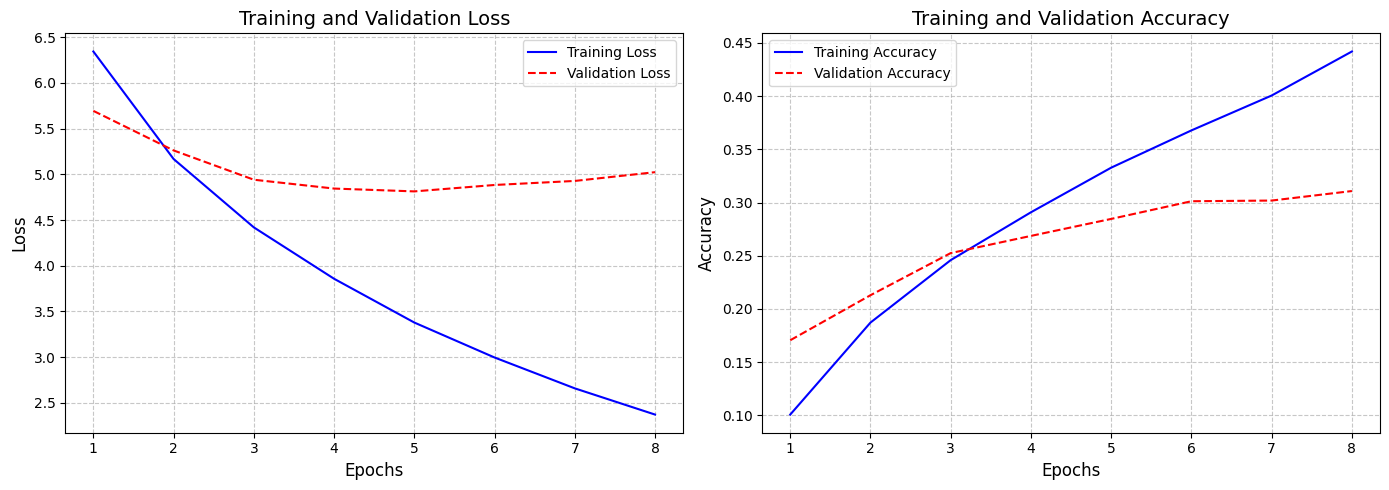

In [22]:
# Visualize Training Loss and Accuracy
print("\n--- Visualizing Training Loss and Accuracy ---")

# Extract loss and accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = np.arange(1, len(train_loss) + 1)

# Create figure with two subplots
plt.figure(figsize=(14, 5))

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red', linestyle='--')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

## Model validation on perplexity

In [23]:
# --- Calculate Perplexity Function ---
def calculate_perplexity(model, x_data_list, y_data, batch_size=16): # x_data_list for multiple inputs
    """
    Calculates perplexity on the given dataset using the trained model.
    Adapted for models with multiple inputs (e.g., [input_ids, attention_mask]).

    Args:
        model (tf.keras.Model): The trained Transformer model.
        x_data_list (list or tuple): A list/tuple of input arrays (e.g., [X_val, mask_val]).
        y_data (np.ndarray): Target token sequences.
        batch_size (int): Batch size for prediction.

    Returns:
        float: Perplexity score.
    """
    print("\n--- Calculating Perplexity ---")
    if len(x_data_list[0]) == 0: # Check the first element of the input list
        print("Warning: Input data for perplexity is empty. Returning inf.")
        return float('inf')
    
    # model.evaluate returns [loss, accuracy], we need the loss for perplexity
    loss = model.evaluate(x_data_list, y_data, batch_size=batch_size, verbose=0)[0]
    
    # Perplexity = exp(average loss)
    perplexity = np.exp(loss)
    
    print(f"Perplexity: {perplexity:.2f}")
    return perplexity

# --- Evaluation Functions ---
def prepare_input_prompts(reference_texts, tokenizer_obj, max_prompt_length=10, sos_token="<SOS>"):
    input_sequences = []
    sos_token_id = tokenizer_obj.word_index.get(sos_token)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)
    
    if sos_token_id is None:
        print(f"Warning: SOS_TOKEN '{sos_token}' ID not found in tokenizer.word_index. Using OOV_TOKEN_ID for prompts.")
        sos_token_id = oov_token_id # Fallback
    if oov_token_id is None: # This should not happen if OOV is correctly set in Tokenizer
        print(f"Error: OOV_TOKEN '{OOV_TOKEN}' ID not found in tokenizer.word_index. Critical issue!")
        return [] # Prevent further errors

    max_valid_id = VOCAB_SIZE_FINAL - 1 # Max index for embedding layer

    for text in reference_texts:
        # Tokenize the prompt text into words and get their IDs
        words_list = text.split()[:max_prompt_length]
        token_sequence_from_text = tokenizer_obj.texts_to_sequences([" ".join(words_list)])[0]
        
        # Prepend SOS_TOKEN_ID and clip any out-of-bounds IDs
        clipped_tokens = [sos_token_id] + [
            token_id if token_id < max_valid_id else oov_token_id
            for token_id in token_sequence_from_text
        ]
        input_sequences.append(clipped_tokens)
    return input_sequences


def generate_text(model, tokenizer_obj, input_prompts, max_generation_length, max_sequence_len_model_input, vocab_size_final, temperature=0.7):
    generated_texts = []
    sos_token_id = tokenizer_obj.word_index.get(SOS_TOKEN)
    eos_token_id = tokenizer_obj.word_index.get(EOS_TOKEN)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)

    if sos_token_id is None or eos_token_id is None or oov_token_id is None:
        print(f"Error: Special token IDs not found for generation. SOS:{sos_token_id}, EOS:{eos_token_id}, OOV:{oov_token_id}")
        return []

    padding_token_id = 0 # Keras pad_sequences uses 0 by default

    for prompt in input_prompts:
        current_seq = prompt.copy()
        
        # Ensure initial prompt tokens are within vocab bounds
        current_seq = [token_id if token_id < vocab_size_final else oov_token_id for token_id in current_seq]

        while len(current_seq) < max_generation_length:
            # Pad the input sequence to the required maxlen for the model.
            input_seq_padded = pad_sequences([current_seq], maxlen=max_sequence_len_model_input, padding='pre', value=padding_token_id)[0]
            # Create mask for the padded input sequence
            mask = (input_seq_padded != 0).astype(int)

            # Predict next token probabilities
            # Model outputs probabilities for the last token position
            probs = model.predict([np.array([input_seq_padded]), np.array([mask])], verbose=0)[0]

            # Apply temperature to probabilities for sampling
            # Mask <OOV> token and padding token to prevent their generation
            if oov_token_id < len(probs):
                probs[oov_token_id] = 0
            if padding_token_id < len(probs):
                probs[padding_token_id] = 0 # Mask padding token from being predicted

            # Normalize probabilities after masking
            sum_probs = np.sum(probs)
            if sum_probs == 0: # Avoid division by zero if all probabilities are masked
                next_token = eos_token_id # Force EOS if nothing else can be predicted
            else:
                probs = probs / sum_probs

                # Apply temperature to probabilities for sampling
                probs = np.exp(np.log(probs + 1e-10) / temperature)
                probs = probs / np.sum(probs) # Re-normalize after temperature

                # Sample next token based on probabilities
                next_token = np.random.choice(len(probs), p=probs)
            
            # Stop criteria: EOS token, padding token, OOV token, or generation limit reached
            if next_token == eos_token_id or next_token == padding_token_id or \
               next_token == oov_token_id or len(current_seq) >= max_generation_length:
                break
            
            current_seq.append(next_token)
        
        # Convert sequence of IDs back to text using the tokenizer
        text = tokenizer_obj.sequences_to_texts([current_seq])[0]
        # Clean up special tokens in the generated text for readability
        text = text.replace(f"{SOS_TOKEN} ", "").replace(f" {EOS_TOKEN}", "").strip()
        text = text.replace(f" {OOV_TOKEN}", "").strip() # Remove OOV tokens from generated text
        generated_texts.append(text)
    return generated_texts


# --- Calculate Perplexity on Validation Dataset ---
print("\n--- Calculating Perplexity on Validation Dataset ---")
if 'X_val' in locals() and 'y_val' in locals() and len(X_val) > 0:
    val_perplexity = calculate_perplexity(lstm_model, X_val, y_val, batch_size=BATCH_SIZE)
    print(f"\nValidation Perplexity: {val_perplexity:.2f}")
else:
    print("Skipping validation perplexity calculation: X_val or y_val not available or empty.")


--- Calculating Perplexity on Validation Dataset ---

--- Calculating Perplexity ---
Perplexity: 123.14

Validation Perplexity: 123.14


# Model Evaluation

## Evaluate Model on Test Dataset (Perplexity, ROUGE L, ROUGE S, ROUGE SU)

In [24]:
# For perplexity, we need test sequences in N-gram format
#inp_sequences_test = get_sequence_of_tokens(texts_for_tokenization_test, tokenizer)
# X_test_lm, y_test_lm, _ = generate_padded_sequences(inp_sequences_test)

# --- Calculate Perplexity Function ---
def calculate_perplexity(model, x_data_list, y_data, batch_size=16): # x_data_list for multiple inputs
    """
    Calculates perplexity on the given dataset using the trained model.
    Adapted for models with multiple inputs (e.g., [input_ids, attention_mask]).

    Args:
        model (tf.keras.Model): The trained Transformer model.
        x_data_list (list or tuple): A list/tuple of input arrays (e.g., [X_val, mask_val]).
        y_data (np.ndarray): Target token sequences.
        batch_size (int): Batch size for prediction.

    Returns:
        float: Perplexity score.
    """
    print("\n--- Calculating Perplexity ---")
    if len(x_data_list[0]) == 0: # Check the first element of the input list
        print("Warning: Input data for perplexity is empty. Returning inf.")
        return float('inf')
    
    # model.evaluate returns [loss, accuracy], we need the loss for perplexity
    loss = model.evaluate(x_data_list, y_data, batch_size=batch_size, verbose=0)[0]
    
    # Perplexity = exp(average loss)
    perplexity = np.exp(loss)
    
    print(f"Perplexity: {perplexity:.2f}")
    return perplexity


# --- Evaluation Functions ---
def prepare_input_prompts(reference_texts, tokenizer_obj, max_prompt_length=10, sos_token="<SOS>"):
    input_sequences = []
    sos_token_id = tokenizer_obj.word_index.get(sos_token)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)
    
    if sos_token_id is None:
        print(f"Warning: SOS_TOKEN '{sos_token}' ID not found in tokenizer.word_index. Using OOV_TOKEN_ID for prompts.")
        sos_token_id = oov_token_id # Fallback
    if oov_token_id is None: # This should not happen if OOV is correctly set in Tokenizer
        print(f"Error: OOV_TOKEN '{OOV_TOKEN}' ID not found in tokenizer.word_index. Critical issue!")
        return [] # Prevent further errors

    max_valid_id = VOCAB_SIZE_FINAL - 1 # Max index for embedding layer

    for text in reference_texts:
        # Tokenize the prompt text into words and get their IDs
        words_list = text.split()[:max_prompt_length]
        token_sequence_from_text = tokenizer_obj.texts_to_sequences([" ".join(words_list)])[0]
        
        # Prepend SOS_TOKEN_ID and clip any out-of-bounds IDs
        clipped_tokens = [sos_token_id] + [
            token_id if token_id < max_valid_id else oov_token_id
            for token_id in token_sequence_from_text
        ]
        input_sequences.append(clipped_tokens)
    return input_sequences


def generate_text(model, tokenizer_obj, input_prompts, max_generation_length, max_sequence_len_model_input, vocab_size_final, temperature=0.7):
    generated_texts = []
    sos_token_id = tokenizer_obj.word_index.get(SOS_TOKEN)
    eos_token_id = tokenizer_obj.word_index.get(EOS_TOKEN)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)

    if sos_token_id is None or eos_token_id is None or oov_token_id is None:
        print(f"Error: Special token IDs not found for generation. SOS:{sos_token_id}, EOS:{eos_token_id}, OOV:{oov_token_id}")
        return []

    padding_token_id = 0 # Keras pad_sequences uses 0 by default

    for prompt in input_prompts:
        current_seq = prompt.copy()
        
        # Ensure initial prompt tokens are within vocab bounds
        current_seq = [token_id if token_id < vocab_size_final else oov_token_id for token_id in current_seq]

        while len(current_seq) < max_generation_length:
            # Pad the input sequence to the required maxlen for the model.
            input_seq_padded = pad_sequences([current_seq], maxlen=max_sequence_len_model_input, padding='post', value=padding_token_id)[0]

            # Predict next token probabilities
            # Changed to pass only one input array
            probs = model.predict(np.array([input_seq_padded]), verbose=0)[0]

            # Apply temperature to probabilities for sampling
            if oov_token_id < len(probs):
                probs[oov_token_id] = 0
            if padding_token_id < len(probs):
                probs[padding_token_id] = 0

            sum_probs = np.sum(probs)
            if sum_probs == 0:
                next_token = eos_token_id
            else:
                probs = probs / sum_probs
                probs = np.exp(np.log(probs + 1e-10) / temperature)
                probs = probs / np.sum(probs)
                next_token = np.random.choice(len(probs), p=probs)
            
            if next_token == eos_token_id or next_token == padding_token_id or \
               next_token == oov_token_id or len(current_seq) >= max_generation_length:
                break
            
            current_seq.append(next_token)
        
        text = tokenizer_obj.sequences_to_texts([current_seq])[0]
        text = text.replace(f"{SOS_TOKEN} ", "").replace(f" {EOS_TOKEN}", "").strip()
        text = text.replace(f" {OOV_TOKEN}", "").strip()
        generated_texts.append(text)
    return generated_texts

def calculate_rouge_l_s_su_scores(generated_texts, reference_texts):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = {'rougeL_f1': [], 'rouge_s': [], 'rouge_su': []}
    
    def get_skip_bigrams(text_words):
        bigrams = set()
        for i in range(len(text_words)):
            for j in range(i + 1, len(text_words)):
                bigrams.add(tuple(sorted((text_words[i], text_words[j]))))
        return bigrams

    for gen, ref in zip(generated_texts, reference_texts):
        gen = gen.strip() if gen and gen.strip() != "empty" else "default"
        ref = ref.strip() if ref and ref.strip() else "default"

        rouge_l = scorer.score(ref, gen)['rougeL'].fmeasure
        scores['rougeL_f1'].append(rouge_l)

        ref_words = ref.split()
        gen_words = gen.split()
        ref_bigrams = get_skip_bigrams(ref_words)
        gen_bigrams = get_skip_bigrams(gen_words)
        
        common_bigrams = ref_bigrams.intersection(gen_bigrams)
        rouge_s = len(common_bigrams) / len(ref_bigrams) if ref_bigrams else 0.0
        scores['rouge_s'].append(rouge_s)

        ref_unigrams = set(ref_words)
        gen_unigrams = set(gen_words)
        
        combined_ref_units = ref_bigrams.union(ref_unigrams)
        combined_gen_units = gen_bigrams.union(gen_unigrams)
        
        common_combined_units = combined_ref_units.intersection(combined_gen_units)
        rouge_su = len(common_combined_units) / len(combined_ref_units) if combined_ref_units else 0.0
        scores['rouge_su'].append(rouge_su)

    return {
        'rougeL_f1': np.mean(scores['rougeL_f1']) if scores['rougeL_f1'] else 0.0,
        'rouge_s': np.mean(scores['rouge_s']) if scores['rouge_s'] else 0.0,
        'rouge_su': np.mean(scores['rouge_su']) if scores['rouge_su'] else 0.0
    }



# --- Evaluate on Test Dataset ---
print("\n--- Evaluating on Test Dataset ---")
# The reference texts for ROUGE scores should be the original cleaned sentences from the test set
test_reference_texts_for_rouge = all_cleaned_sentences_test

# Prepare prompts for test data. These prompts are taken from the beginning of each test sentence.
input_prompts_test = prepare_input_prompts(test_reference_texts_for_rouge, tokenizer, max_prompt_length=10)
max_generation_length = max_sequence_len_train + 10 # Allow generation longer than training sequences

if 'lstm_model' in locals() and len(predictors_train) > 0:
    if model_input_maxlen <= 0:
        print("Error: Model input maxlen is too small for generation. Cannot proceed.")
        test_generated_texts = []
    else:
        test_generated_texts = generate_text(lstm_model, tokenizer, input_prompts_test,
                                             max_generation_length, model_input_maxlen, VOCAB_SIZE_FINAL, temperature=0.7)
else:
    print("Model not trained or training data was empty. Skipping text generation.")
    test_generated_texts = []


# --- Calculate and Print Results (even if generation was skipped) ---
if test_generated_texts and len(test_reference_texts_for_rouge) > 0:
    test_rouge_scores = calculate_rouge_l_s_su_scores(test_generated_texts, test_reference_texts_for_rouge)
    
    # Calculate perplexity on the full test set (using predictors_test_padded and label_test)
    if len(predictors_test_padded) > 0 and len(label_test) > 0:
        test_perplexity = calculate_perplexity(lstm_model, predictors_test_padded, label_test, BATCH_SIZE)
        print(f"Test Perplexity: {test_perplexity:.2f}")
    else:
        print("Test data for perplexity is empty. Skipping perplexity calculation.")
        
    print(f"Test ROUGE Scores:")
    print(f" ROUGE-L F1: {test_rouge_scores['rougeL_f1']:.4f}")
    print(f" ROUGE-S: {test_rouge_scores['rouge_s']:.4f}")
    print(f" ROUGE-SU: {test_rouge_scores['rouge_su']:.4f}")


--- Evaluating on Test Dataset ---

--- Calculating Perplexity ---
Perplexity: 106.40
Test Perplexity: 106.40
Test ROUGE Scores:
 ROUGE-L F1: 0.2582
 ROUGE-S: 0.3412
 ROUGE-SU: 0.3638


## Samples of generated text

In [25]:
print("\n--- Sample Generated Texts ---")
for i, (gen_text, ref_text) in enumerate(zip(test_generated_texts[:5], test_reference_texts_for_rouge[:5])): # Print up to 5 samples
    print(f"Sample {i+1}:")
    print(f"Generated: '{gen_text}'")
    print(f"Reference: '{ref_text[:100]}...'") # Truncate reference for display
    print("-" * 50)


--- Sample Generated Texts ---
Sample 1:
Generated: '<OOV> in the realm of where characters often human lens sedentary monitor neatly conventions inconclusive greenery heavily addition bring determined hope personality hunger harboring abused inclusivity reallocation dependent contend precedent techniques drugs tension dialogue uninhabitable merit extension remotely member selfsufficiency abused contributors implement rocky delved highlighted buses perfectly obsolete obstacle embodying conventions abnormalities for knowledge of circumstances <eos> <eos> <eos> <eos> <eos> and disable'
Reference: 'in the realm of literature where characters often embody human natures complexities the intriguing t...'
--------------------------------------------------
Sample 2:
Generated: '<OOV> the story follows a cowboy accustomed to the obsolete low recount reverberate lined adventurousness craft embarrassment manufacturing evaluate whale humpback right feel cyber join attract horsemanship bustling as